In [465]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

In [466]:
df = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [467]:
df = df.drop_duplicates(subset=['datetime'])

In [468]:
df['datetime'] = df['datetime'].apply(lambda x: x.split("+")[0])

In [469]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [470]:
df = df[df.Consumption.notnull()]

In [471]:
df.columns

Index(['Perimeter', 'Nature', 'Dated', 'Hours', 'Consumption', 'Thermal',
       'Wind', 'Solar', 'Hydraulic', 'Bioenergies', 'Ech. physical',
       'datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b

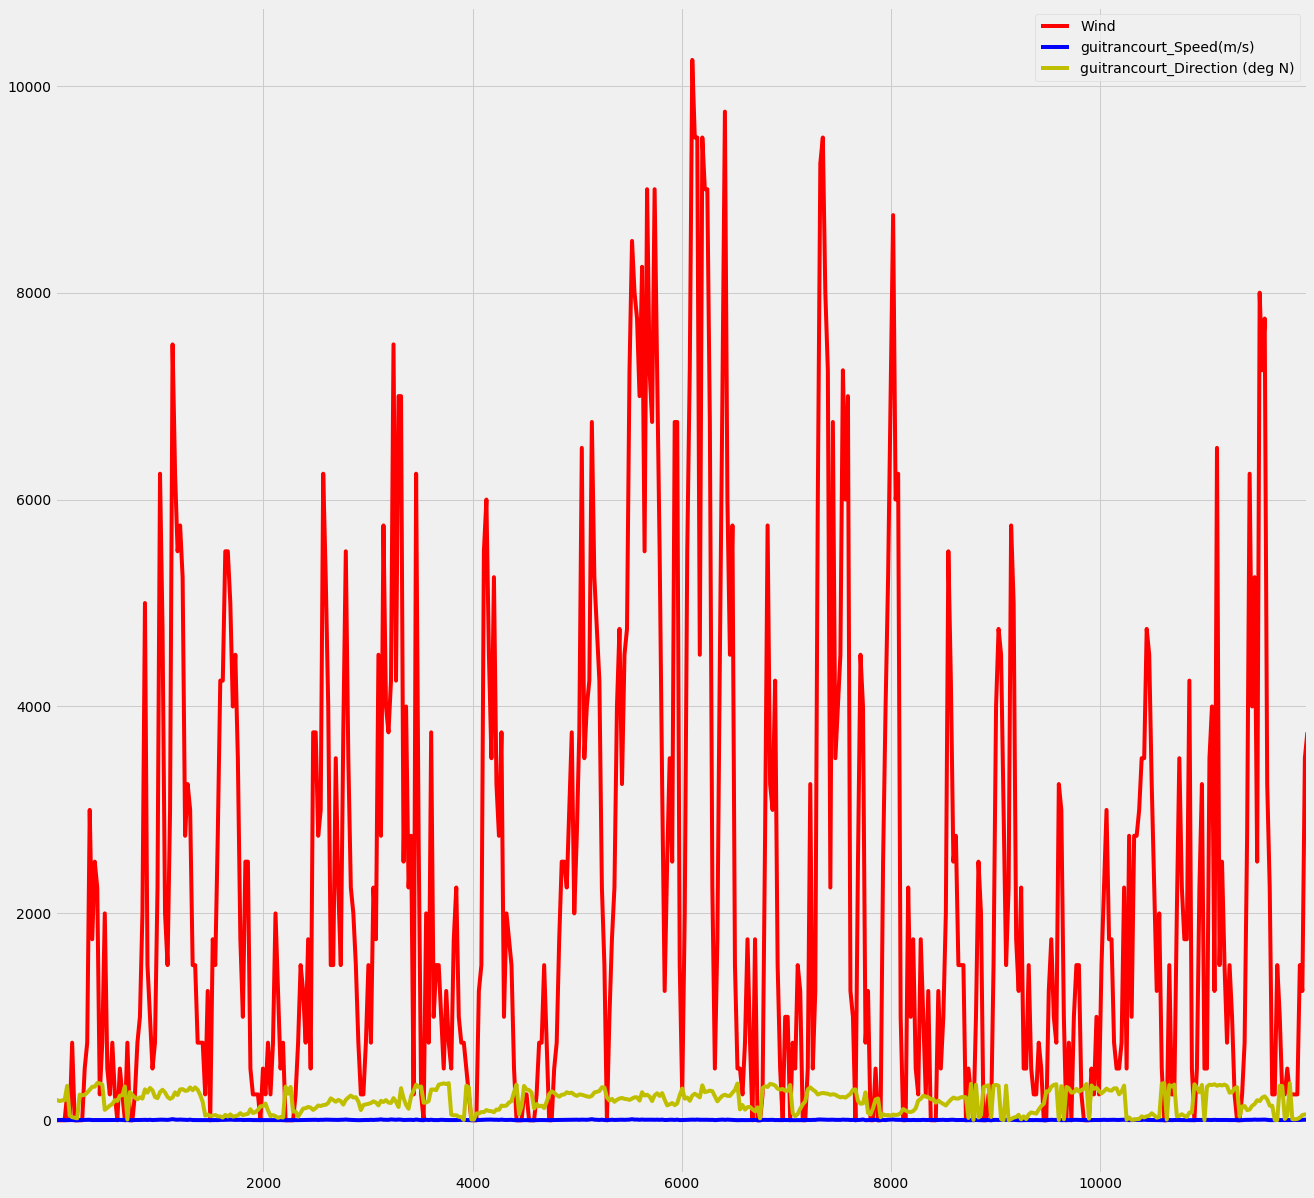

In [472]:
df[df['guitrancourt_Speed(m/s)'].notnull()].head(500)[['Wind','guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)']].astype(float).plot(style=['r','b','y'],figsize=(20,20))

In [473]:
columns_use = ['datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [474]:
agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])

In [475]:
agg_df.columns = agg_df.columns.map('_'.join)

In [476]:
agg_df = agg_df.reset_index()

In [477]:
merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')

In [478]:
merge_df = merge_df.fillna(method='ffill')

In [479]:
data = merge_df.copy()

In [480]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [481]:
#data['PJM_Load_MW_mean_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['Wind_sum_mean_daily'] = data['Wind_sum'].rolling(24).mean()
data['Wind_sum_mean_weekly'] = data['Wind_sum'].rolling(24*7).mean()
data['Wind_sum_mean_monthly'] = data['Wind_sum'].rolling(24*30).mean()

In [482]:
data['Wind_sum_std_daily'] = data['Wind_sum'].rolling(24).std()
data['Wind_sum_std_weekly'] = data['Wind_sum'].rolling(24*7).std()
data['Wind_sum_std_monthly'] = data['Wind_sum'].rolling(24*30).std()

In [483]:
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek
data['quarter'] = data['datetime'].dt.quarter
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year 
data['dayofyear'] = data['datetime'].dt.dayofyear
data['dayofmonth'] = data['datetime'].dt.day
data['weekofyear'] = data['datetime'].dt.weekofyear

In [484]:
data['target'] = data['Wind_sum'].shift(-18)

In [486]:
data.dropna(axis=0, how='any', inplace=True)

In [487]:
np.sqrt(mean_squared_error(y_true=data['target'],y_pred=data['Wind_sum']))

9528.08196811996

In [488]:
mean_absolute_error(y_true=data['target'],y_pred=data['Wind_sum'])

6506.450067721582

In [489]:
mean_absolute_percentage_error(data['target'],data['Wind_sum'])

C:\Users\Acer\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Acer\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


nan

In [490]:
data = data.drop(columns=['datetime'])

In [491]:
X_train = data[data.year.isin([2017,2018])].drop(columns=['target','year','month'])
X_test = data[data.year.isin([2019])].drop(columns=['target','year','month'])
y_train = data[data.year.isin([2017,2018])][['target']]
y_test = data[data.year.isin([2019])][['target']]

In [499]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate= 0.2)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:7831.61865	validation_1-rmse:13563.29590
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6920.41797	validation_1-rmse:12649.18945
[2]	validation_0-rmse:6217.74365	validation_1-rmse:12013.87305
[3]	validation_0-rmse:5693.57959	validation_1-rmse:11560.07617
[4]	validation_0-rmse:5309.59766	validation_1-rmse:11079.78223
[5]	validation_0-rmse:5007.88037	validation_1-rmse:10835.08691
[6]	validation_0-rmse:4780.23926	validation_1-rmse:10888.39258
[7]	validation_0-rmse:4542.71191	validation_1-rmse:10865.54688
[8]	validation_0-rmse:4401.02930	validation_1-rmse:10724.63965
[9]	validation_0-rmse:4282.33447	validation_1-rmse:10674.25098
[10]	validation_0-rmse:4190.64551	validation_1-rmse:10499.02441
[11]	validation_0-rmse:4071.80005	validation_1-rmse:10450.73633
[12]	validation_0-rmse:3986.35449	validation_1-rmse:10417.89746
[13]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [500]:
pyplot.rcParams["figure.figsize"] = (20,10)

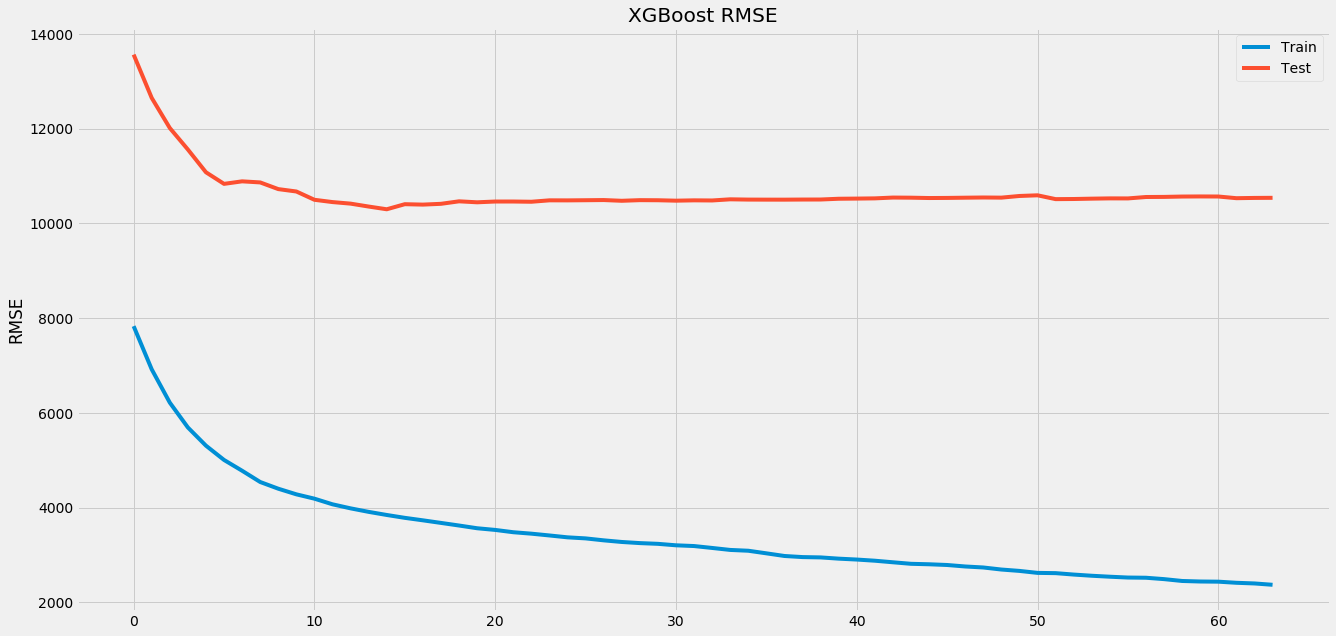

In [501]:
# retrieve performance metrics
results = reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')
pyplot.show()

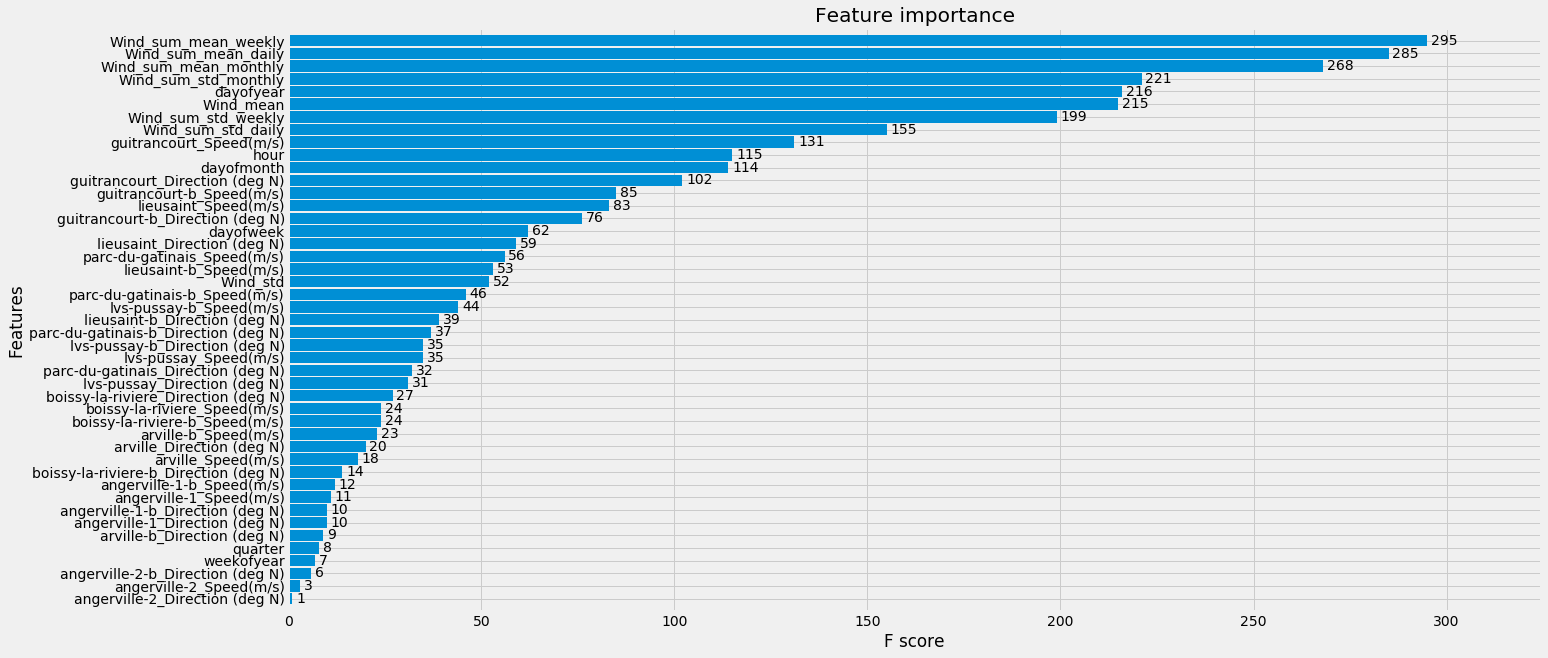

In [502]:
_ = plot_importance(reg, height=0.9)

In [503]:
np.sqrt(mean_squared_error(y_true=y_test,y_pred=reg.predict(X_test)))

10298.877878698635

In [504]:
mean_absolute_error(y_true=y_test,y_pred=reg.predict(X_test))

7510.69479733513

In [498]:
mean_absolute_percentage_error(y_test,reg.predict(X_test))

C:\Users\Acer\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


inf

In [458]:
test_result = data[data.year.isin([2019])].copy()
test_result['prediction'] = reg.predict(X_test)

In [459]:
test_result['error'] = test_result['target'] - test_result['prediction']
test_result['abs_error'] = test_result['error'].apply(np.abs)
error_by_day = test_result.groupby(['year','month','dayofmonth']) \
    .mean()[['target','prediction','error','abs_error']]

In [460]:
test_result.sort_values('abs_error', ascending=False)

,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),lieusaint_Speed(m/s),lieusaint_Direction (deg N),lvs-pussay_Speed(m/s),lvs-pussay_Direction (deg N),parc-du-gatinais_Speed(m/s),parc-du-gatinais_Direction (deg N),arville_Speed(m/s),arville_Direction (deg N),...,year,dayofyear,dayofmonth,weekofyear,target,Wind_std_lag,Wind_mean_lag,prediction,error,abs_error
25714,5.28,271.0,7.13,232.0,7.29,233.0,8.33,220.0,8.29,221.0,...,2019,342,8,49,44250.0,176.776695,22125.0,28499.960938,15750.039062,15750.039062
25832,8.86,275.0,8.26,269.0,8.53,274.0,8.32,270.0,8.30,270.0,...,2019,347,13,50,44250.0,176.776695,22125.0,28500.015625,15749.984375,15749.984375
25715,5.28,271.0,7.13,232.0,7.29,233.0,8.33,220.0,8.29,221.0,...,2019,342,8,49,44000.0,0.000000,22000.0,28499.990234,15500.009766,15500.009766
25712,6.29,226.0,7.15,221.0,7.99,228.0,7.35,227.0,7.38,226.0,...,2019,342,8,49,44000.0,0.000000,22000.0,28499.990234,15500.009766,15500.009766
25717,5.28,271.0,7.13,232.0,7.29,233.0,8.33,220.0,8.29,221.0,...,2019,342,8,49,44000.0,0.000000,22000.0,28499.990234,15500.009766,15500.009766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21006,3.04,260.0,2.14,278.0,2.22,295.0,1.79,290.0,1.81,290.0,...,2019,146,26,21,3250.0,176.776695,1625.0,3250.000000,0.000000,0.000000
21391,1.41,158.0,1.37,192.0,1.27,190.0,1.45,184.0,1.45,186.0,...,2019,162,11,24,3250.0,530.330086,1625.0,3250.000000,0.000000,0.000000
21392,1.41,158.0,1.37,192.0,1.27,190.0,1.45,184.0,1.45,186.0,...,2019,162,11,24,3500.0,0.000000,1750.0,3500.000000,0.000000,0.000000
20837,1.54,322.0,1.41,232.0,1.33,299.0,2.01,224.0,1.98,224.0,...,2019,139,19,20,3250.0,176.776695,1625.0,3250.000000,0.000000,0.000000


In [464]:
# Over forecasted days
error_by_day.sort_values('abs_error', ascending=False).head(20)

target    prediction         error     abs_error
year month dayofmonth                                                        
2019 12    8           41614.583333  28499.970703  13114.612142  13114.612142
           12          39406.250000  28500.056641  10906.194010  10906.194010
           21          38375.000000  28500.046875   9874.953776   9874.953776
           13          37218.750000  27583.359375   9635.390340   9635.397664
     11    26          37177.083333  27677.060547   9500.022298   9500.025391
     12    19          36260.416667  27760.472656   8499.944499   8499.944499
     11    1           36833.333333  28499.984375   8333.348145   8333.348145
     12    22          34864.583333  27031.283203   7833.299683   7833.307007
     9     28          33218.750000  26270.816406   6947.934204   6947.939006
     11    27          34760.416667  28104.169922   6656.246908   6656.246908
     12    14          28260.416667  22520.843750   5739.572042   5739.572367
           18          33416.666667  28312.550781   5104.115723   5104.126139
     10    15          31218.750000  26135.431641   5083.317627   5083.341227
     8     9           33072.916667  28145.804688   4927.112142   4927.114258
     12    26          25093.750000  20364.621094   4729.129745   4729.144547
     11    3           32177.083333  27614.582031   4562.501465   4562.516927
     12    7           29739.583333  25208.306641   4531.276082   4531.277303
           23          29885.416667  25937.515625   3947.900391   3947.913900
     11    2           28260.416667  24541.648438   3718.767497   3718.770915
           22          27843.750000  24177.093750   3666.656982   3666.675293

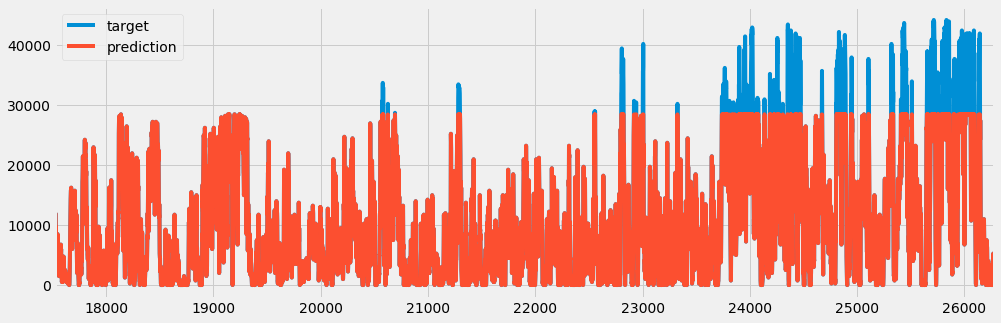

In [449]:
_ = test_result[['target','prediction']].plot(figsize=(15, 5))